In [198]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

###  Function to Generate Data

In [199]:
# #Generating data(k = number of Gaussain/clusters, mi = initilaised means, si = initialised variances,
# dim = dimension,N = dimension as (N*dim))

def generateND(k,mi,si,dim,N = 1000):
    x = np.ones(dim)
    X = np.array([x])
    for i in range(k):

        m = []
        for i in range(dim):
            m.append(i+i*3+np.random.rand())
        mean = tuple(m)
        mi.append(mean)
        mat = np.random.rand(dim,dim)*2
        cov = mat@mat.T
        si.append(cov)
        s = np.random.multivariate_normal(mean, cov, N)
        X = np.concatenate([X,s],axis=0)
    plt.scatter(X[:, 0], X[:, 1])        
    return X,mi,si


def generate1D(k,mi,si,N = 1000):
    y = np.array([])
    for i in range(k):

        mean = i*2+np.random.rand()
        mi.append(mean)
        mat = (np.random.rand())*5
        si.append(mat)
        s = np.random.normal(mean, mat, N)
        y = np.concatenate([y,s],axis=0)
    return y,mi,si


### K-means Function (for initialization of GMM)

In [200]:

#K-means
def intial_mu_k(k,X):
    return np.random.randint(low = 0,high = X.shape[0],size = k)

def cost_function(mu,cluster_id,X):
    cost = 0
    for i in range(X.shape[0]):
        cost += np.sum((mu[cluster_id[i]]-X[i])**2)
    return cost

def K_means(k,X,max_iters = 100):
    mu_index = intial_mu_k(k,X)
    cluster_id = np.zeros(X.shape[0],dtype=int)
    
    num_iters = 0
    error = 1000
    cost_values = []
    
    if X.shape[0] == X.size:
        mu_data = np.zeros(k) 
    
    else:    
        mu_data = np.zeros((k,X.shape[1]))
    
    for i in range(k):
        
        if X.shape[0] == X.size:
            mu_data[i] = X[mu_index[i]]
            
        else:    
            for j in range(X.shape[1]):
                mu_data[i][j] = X[mu_index[i]][j]
            
    while (num_iters < max_iters) and (error > 0.001):
        
#   Updating Cluster_ids
        for i in range(X.shape[0]):
            if X.shape[0] == X.size:
                distances = (mu_data-X[i])**2

            else:   
                distances = np.sum((mu_data-X[i])**2,axis = 1)
                
            min_dist = np.amin(distances)
            index = -1
            for j in range(mu_data.shape[0]):
                if distances[j] == min_dist:
                    index = j
                    break
            cluster_id[i] = index
            

# Update mu's
        if X.shape[0] == X.size:
           new_mu_data = np.zeros(k)
            
        else:    
            new_mu_data = np.zeros((k,X.shape[1]))
    
        cluster_size = np.zeros(k)
        for i in range(X.shape[0]):
            cluster_size[cluster_id[i]] = cluster_size[cluster_id[i]]+1
            new_mu_data[cluster_id[i]] = new_mu_data[cluster_id[i]]+X[i]
        
        for i in range(k):
            if cluster_size[i] == 0:
                cluster_size[i] = 1
                
            new_mu_data[i] = new_mu_data[i]/cluster_size[i]
        
        J = cost_function(mu_data,cluster_id,X)
        cost_values.append(J)
        error = np.sum(np.abs(mu_data-new_mu_data))
        mu_data = new_mu_data
        num_iters += 1
#         if num_iters%4 == 0 :
#             print("iteration",num_iters)
#             print("error:",error)
#             print("cost:",J)
        
    return mu_data,cluster_id,cost_values,num_iters

### EM on GMM

In [201]:
# GMM

# X-->N*D
# Z-->N*K

# for needed intialization needed N_k,mu_k,sigma_k,pi_k


### intiliase_for_GMM: with help of k-means we initialize mu_k,sigma_k,pi_k
def intiliase_for_GMM(mu,cluster_id,X,k):
    mu_k = []
    sigma_k = []
    pi_k = []
    clusters = []   
    cluster_size = np.zeros(k)
    Z = np.zeros((X.shape[0],k))

    for i in range(k):
        mu_k.append(mu[i])
        clusters.append([])


    for i in range(X.shape[0]):
        cluster_size[cluster_id[i]] = cluster_size[cluster_id[i]]+1
        clusters[cluster_id[i]].append(X[i])


    for i in range(k):
        A = np.asarray(clusters[i])
        sigma_k.append(np.dot((A-mu_k[i]).T,(A-mu_k[i]))/cluster_size[i])
        pi_k.append(cluster_size[i]/X.shape[0])
        
        
    return mu_k,sigma_k,pi_k,Z
    

### Compute: Function to compute likilihood
def compute(X,pi_k,mu_k,sigma_k,k):
    temp = np.zeros((X.shape[0],k))
    
    for i in range(k):
        p = pi_k[i]
        liklihood = multivariate_normal.pdf(X,mu_k[i],sigma_k[i])
        temp[:,i] = p*liklihood
        
    return np.sum(np.log(np.sum(temp,axis = 1)))
    
### E_step: E-Step in EM Algorithm
def E_step(Z,mu_k,sigma_k,pi_k,X,k):
    for i in range(X.shape[0]):
        for j in range(k):
            Z[i,j] = pi_k[j]*multivariate_normal.pdf(X[i],mu_k[j],sigma_k[j])
    total_row_sum = Z.sum(axis=1)[:,np.newaxis]
    Z = Z/total_row_sum
    return Z


### M_step: M-step in EM Algorithm
def M_step(X,Z,mu_k,sigma_k,pi_k,k):
    count_each_cluster = np.sum(Z,axis=0)
    N = X.shape[0]
    for i in range(k):
    # pi_k^
        pi_k[i] = count_each_cluster[i]/N
    # mu_k^
        soft_sum = 0
        for j in range(X.shape[0]):
            soft_sum += (Z[j,i]*X[j])
        mu_k[i] = soft_sum/count_each_cluster[i]
    # sigma_k^
        if X.shape[0] == X.size:
            soft_sum = 0
        else:
            soft_sum = np.zeros((X.shape[1],X.shape[1]))
        
        for j in range(X.shape[0]):
            soft_sum += (Z[j,i]* np.outer(X[j]-mu_k[i],X[j]-mu_k[i]))
        sigma_k[i] = soft_sum/count_each_cluster[i]
    return mu_k,sigma_k,pi_k
    
### EM_main: Implementation of EM algo on GMM with help of above functions
def EM_main(X,mu,cluster_id,k,max_iters = 100):
    mu_k,sigma_k,pi_k,Z = intiliase_for_GMM(mu,cluster_id,X,k)
    ll = []
    
    old_ll = compute(X,pi_k,mu_k,sigma_k,k)
    ll.append(old_ll)

    num_iters = 0
    error = 10.0
    while (num_iters) < max_iters and error > 1:
        Z = E_step(Z,mu_k,sigma_k,pi_k,X,k)
        mu_k ,sigma_k,pi_k = M_step(X,Z,mu_k,sigma_k,pi_k,k)
        new_ll = compute(X,pi_k,mu_k,sigma_k,k)
        ll.append(new_ll)
        
        error = np.abs(old_ll-new_ll)
        old_ll = new_ll
        num_iters += 1
        print("Iteration",num_iters)
        print("Mean", mu_k)
        print("sigma",sigma_k)
        print("pi_k",pi_k,'\n')
#         print(error)
    
    return ll,mu_k,sigma_k,pi_k,num_iters

In [202]:
### importing this only to check my answer
# from sklearn import mixture
# g = mixture.GaussianMixture(n_components=k)

# we can change k value here
k = 3

In [203]:
#EX-1

# 1D
np.random.seed(666)
mi = []
si = []
y,mi,si = generate1D(k,mi,si)
print("k_means")
mu,cluster_id,cost,num_iters = K_means(k,y)
print("k_means ended")
print("GMM")
l,mu_k,sigma_k,pi_k,num_iters = EM_main(y,mu,cluster_id,k)
print("GMM_ENDED")

k_means
k_means ended
GMM
Iteration 1
Mean [1.9325177823466206, 6.338431811937883, -3.3385034117972006]
sigma [array([[2.79237908]]), array([[4.23975774]]), array([[6.25028399]])]
pi_k [0.42774954304817286, 0.35931574514792153, 0.2129347118039052] 

Iteration 2
Mean [1.9510718415644757, 6.218778008486339, -3.2027564303334253]
sigma [array([[3.29472944]]), array([[4.73048663]]), array([[6.98664556]])]
pi_k [0.4223084971567429, 0.36294508781865087, 0.21474641502460542] 

Iteration 3
Mean [1.9656522889355252, 6.130955531652215, -3.1080805657006647]
sigma [array([[3.69656046]]), array([[5.09443303]]), array([[7.53531295]])]
pi_k [0.4196272446918344, 0.36500049119118005, 0.21537226411698654] 

Iteration 4
Mean [1.9785213260147438, 6.060387280407875, -3.0352847701467587]
sigma [array([[4.03555359]]), array([[5.38407129]]), array([[7.96877972]])]
pi_k [0.4181088043790191, 0.3663519270957923, 0.21553926852518668] 

Iteration 5
Mean [1.9905241687226054, 6.000803155082153, -2.976254153202694]
si

true mean values
[0.7004371218578347, 2.1490430240467435, 4.643863321171351] 

Estimated
[2.066802160884268, 5.723399072410769, -2.7338131053043138] 

true variances
[4.220933214252173, 4.320756586563949, 2.594129740020947] 

Estimated
[array([[5.74203422]]), array([[6.68407545]]), array([[9.78488476]])] 

weights [0.41596262591322586, 0.37012022324437976, 0.2139171508423951]


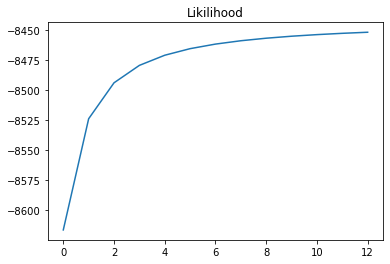

In [204]:
x = []
for i in range(num_iters+1):
    x.append(i)
plt.plot(x,l)
plt.title("Likilihood")

# Here true values,estimated values indexes varies(if we campare by index to index) so,to check we need to see and select best 
# possible pair manually  

print("true mean values")
print(mi,'\n')
print("Estimated")
print(mu_k,'\n')
print("true variances")
print(si,'\n')
print("Estimated")
print(sigma_k,'\n')

print("weights",pi_k)
# g.fit(y.reshape(-1,1))
# g.means_

k_means
k_means ended
GMM
Iteration 1
Mean [array([0.77548415, 4.27130064]), array([-0.59173908,  4.28141785]), array([2.2520328 , 5.44374721])]
sigma [array([[0.1805763 , 0.06976109],
       [0.06976109, 0.36654623]]), array([[0.45600101, 0.11561051],
       [0.11561051, 0.04973097]]), array([[0.99525569, 0.35934948],
       [0.35934948, 0.18420909]])]
pi_k [0.5591170691956326, 0.2777089490925324, 0.1631739817118346] 

Iteration 2
Mean [array([0.82019289, 4.26886666]), array([-0.48002177,  4.30103426]), array([2.18350045, 5.4138138 ])]
sigma [array([[0.18483561, 0.09230101],
       [0.09230101, 0.40443136]]), array([[0.51567097, 0.12509696],
       [0.12509696, 0.04649944]]), array([[1.17402213, 0.43292112],
       [0.43292112, 0.2044862 ]])]
pi_k [0.5251725807416814, 0.3119179364377461, 0.16290948282057285] 

Iteration 3
Mean [array([0.85560175, 4.26121735]), array([-0.38350908,  4.31609607]), array([2.08642326, 5.38324736])]
sigma [array([[0.18617817, 0.11182906],
       [0.11182906

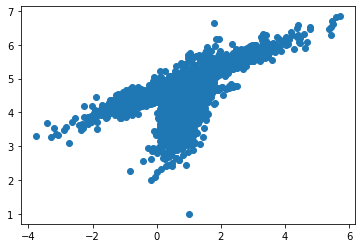

In [205]:
#2D

mi = []
si = []
X,mi,si = generateND(k,mi,si,2)
print("k_means")
mu,cluster_id,cost,num_iters = K_means(k,X)
print("k_means ended")
print("GMM")
l,mu_k,sigma_k,pi_k,num_iters = EM_main(X,mu,cluster_id,k)
print("GMM_ENDED")

true mean values
[(0.9066670921426017, 4.9587089849893085), (0.1369016666246149, 4.378004883737309), (0.8926610507428404, 4.102048549462573)] 

Estimated
[array([0.89393771, 4.07944675]), array([0.1027003 , 4.37206011]), array([0.90089501, 4.95129179])] 

true variances
[array([[2.64041866, 0.98410606],
       [0.98410606, 0.39491146]]), array([[0.57604076, 0.10460206],
       [0.10460206, 0.01983763]]), array([[0.15692039, 0.16279511],
       [0.16279511, 0.49109659]])] 

Estimated
[array([[0.16506868, 0.17083987],
       [0.17083987, 0.50231628]]), array([[0.58114718, 0.10605567],
       [0.10605567, 0.02017347]]), array([[2.58480714, 0.95363314],
       [0.95363314, 0.3800893 ]])] 

weights [0.33937502828958555, 0.327997073037376, 0.3326278986730395]


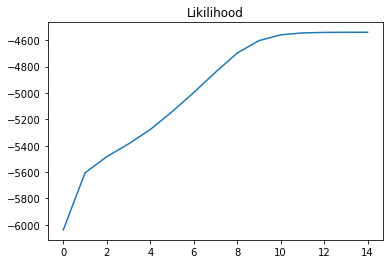

In [206]:
x = []
for i in range(num_iters+1):
    x.append(i)
plt.plot(x,l)
plt.title("Likilihood")
print("true mean values")
print(mi,'\n')
print("Estimated")
print(mu_k,'\n')
print("true variances")
print(si,'\n')
print("Estimated")
print(sigma_k,'\n')

print("weights",pi_k)
# g.fit(X)
# g.means_

In [ ]:
#EX-2

#1D
mi = []
si = []

np.random.seed(99)


y,mi,si = generate1D(k,mi,si)
print("k_means")
mu,cluster_id,cost,num_iters = K_means(k,y)
print("k_means ended")
print("GMM")
l,mu_k,sigma_k,pi_k,num_iters = EM_main(y,mu,cluster_id,k)
print("GMM_ENDED")


true mean values
[0.6722785586307918, 2.862224200810581, 4.590967043258508] 

Estimated
[5.344495764199838, -0.48839474519179626, 2.8626681792549675] 

true variances
[2.4403919962029184, 2.7577883908392464, 1.592297883686316] 

Estimated
[array([[2.66751533]]), array([[3.71669366]]), array([[2.08592981]])] 

weights [0.34932219514452373, 0.27909238227116157, 0.37158542258431493]


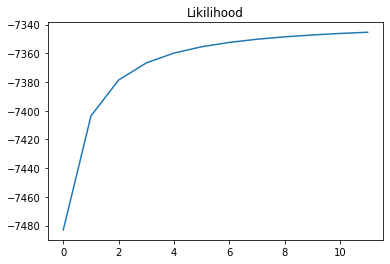

In [208]:
x = []
for i in range(num_iters+1):
    x.append(i)
plt.plot(x,l)
plt.title("Likilihood")
print("true mean values")
print(mi,'\n')
print("Estimated")
print(mu_k,'\n')
print("true variances")
print(si,'\n')
print("Estimated")
print(sigma_k,'\n')

print("weights",pi_k)
# g.fit(y.reshape(-1,1))
# g.means_

In [ ]:
#2D
mi = []
si = []

X,mi,si = generateND(k,mi,si,3)
# X,mi,si = generateND(k,mi,si,2)
print("k_means")
mu,cluster_id,cost,num_iters = K_means(k,X)
print("k_means ended")
print("GMM")
l,mu_k,sigma_k,pi_k,num_iters = EM_main(X,mu,cluster_id,k)
print("GMM_ENDED")

In [ ]:
x = []
for i in range(num_iters+1):
    x.append(i)
plt.plot(x,l)
plt.title("Likilihood")
print("true mean values")
print(mi,'\n')
print("Estimated")
print(mu_k,'\n')
print("true variances")
print(si,'\n')
print("Estimated")
print(sigma_k,'\n')

print("weights",pi_k)
# g.fit(X)
# g.means_


### Summary

<h4> I applied EM on 2 sets of data </h4>
<h4> I used k-means to initialise the values of means,variances,pi for EM algorithm because since there are many local maximas are possible for our likilihood function ,we focus on choosing best possible solution by initializing by k-means</h4>
<h4> Here I used multivarate_normal,since my covariance matrix is singular in most of the cases and i can't get rid of it,so instead i used multivariate_normal function from scipy.stats to overcome this issue.</h4>
<h4> On applying on varies datasets , I found that in a rare case my algorithm gives slightly differed values.(which can be solved by keeping thershold to less than 0.01 in EM_main function) </h4>
<h4> since I generated 1000 from each gaussian.so in my case i can check correctness of mean,variance parameters with help of pi_k or weights parameter </h4> 

#### Note: if we run for more time (like by changing the threshold value) we will get better results.

In [ ]:
# m = [1,1]
# m.append(2)
# tuple(m)